Install dependencies

In [1]:
pip install pandas matplotlib seaborn

Unexpected games for Barcelona when they played better:
                     date leagueName homeTeamName awayTeamName  homeGoals  awayGoals  \
1429  2015-11-21 21:15:00    La Liga  Real Madrid    Barcelona          0          4   
3404  2017-04-23 19:45:00    La Liga  Real Madrid    Barcelona          2          3   
6404  2017-12-23 12:00:00    La Liga  Real Madrid    Barcelona          0          3   

     ActualOutcome ExpectedOutcome  
1429             A               H  
3404             A               H  
6404             A               H  


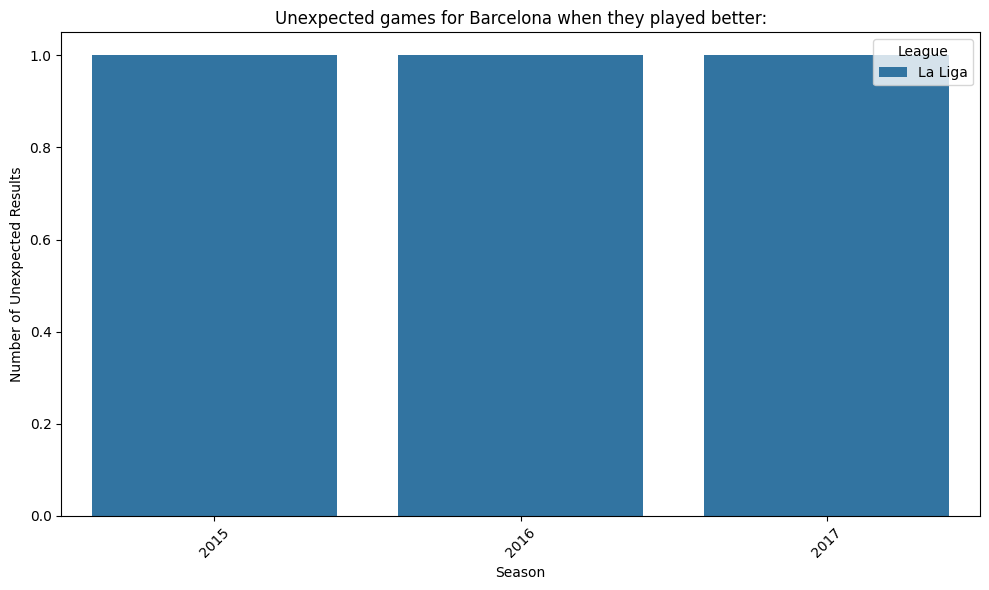

Unexpected games for Barcelona when they played worse:
                      date leagueName         homeTeamName         awayTeamName  homeGoals  \
5065   2014-09-24 21:00:00    La Liga               Malaga            Barcelona          0   
4970   2014-11-01 19:00:00    La Liga            Barcelona           Celta Vigo          0   
4950   2014-12-13 15:00:00    La Liga               Getafe            Barcelona          0   
4902   2015-01-04 20:00:00    La Liga        Real Sociedad            Barcelona          1   
4881   2015-02-21 15:00:00    La Liga            Barcelona               Malaga          0   
4779   2015-04-11 19:00:00    La Liga              Sevilla            Barcelona          2   
4748   2015-05-23 17:30:00    La Liga            Barcelona  Deportivo La Coruna          2   
1362   2015-09-23 22:00:00    La Liga           Celta Vigo            Barcelona          4   
1379   2015-10-03 18:00:00    La Liga              Sevilla            Barcelona          2   
1450 

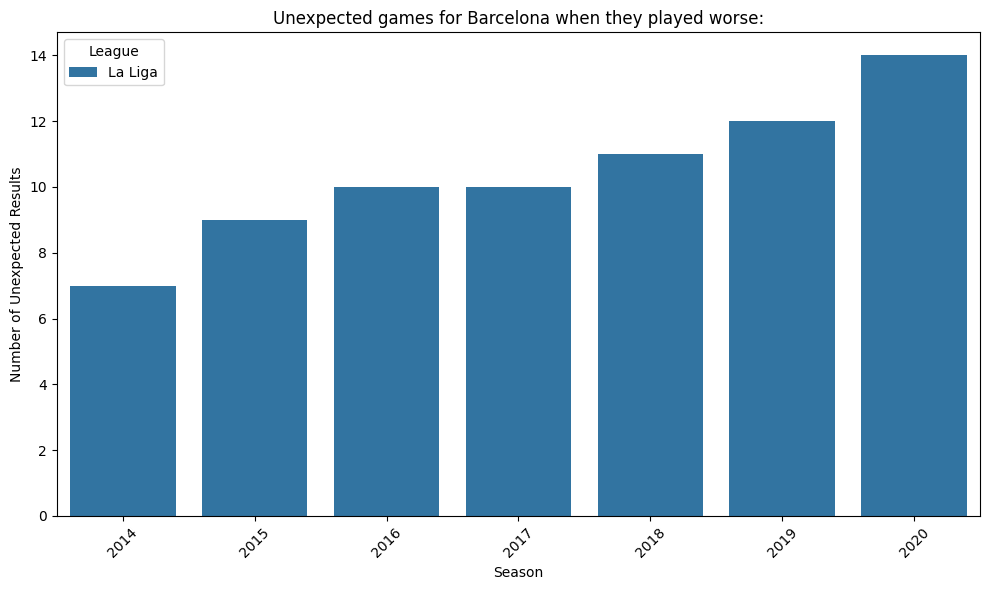

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import calendar

# Set display options to ensure all columns are shown
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Function to determine the actual outcome of a game
def determine_actual_outcome(row):
    if row['homeGoals'] > row['awayGoals']:
        return 'H'  # Home win
    elif row['homeGoals'] < row['awayGoals']:
        return 'A'  # Away win
    else:
        return 'D'  # Draw


# Function to determine the expected outcome based on the lowest bookie coefficient
def determine_expected_outcome(row):
    odds = {
        'H': min(row['B365H'], row['BWH'], row['IWH'], row['PSH'], row['WHH'], row['VCH'], row['PSCH']),
        'D': min(row['B365D'], row['BWD'], row['IWD'], row['PSD'], row['WHD'], row['VCD'], row['PSCD']),
        'A': min(row['B365A'], row['BWA'], row['IWA'], row['PSA'], row['WHA'], row['VCA'], row['PSCA'])
    }
    return min(odds, key=odds.get)  # Return the key with the lowest value


def plot_unexpected_games(unexpected_games_sorted, team, criteria):
    # Assuming you have your dataframe ready as 'unexpected_games_sorted'
    # Group by league and season and count the number of unexpected results
    grouped_data = unexpected_games_sorted.groupby(['leagueName', 'season']).size().reset_index(name='count')

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x='season', y='count', hue='leagueName', data=grouped_data)
    plt.title('Unexpected Results by League and Season')
    plt.title(f"Unexpected games for {team} when they played {criteria}:")
    plt.xlabel('Season')
    plt.ylabel('Number of Unexpected Results')
    plt.xticks(rotation=45)
    plt.legend(title='League')
    plt.tight_layout()
    plt.show()


def plot_monthly_charts0(unexpected_games_sorted):
    # Assuming you have your dataframe ready as 'unexpected_games_sorted'
    # Extract month from the date
    unexpected_games_sorted['month'] = pd.to_datetime(unexpected_games_sorted['date']).dt.month
    unexpected_games_sorted['month_name'] = unexpected_games_sorted['month'].apply(lambda x: calendar.month_name[x])


    # Iterate over each combination of league and season
    for league in unexpected_games_sorted['leagueName'].unique():
        for season in unexpected_games_sorted['season'].unique():
            # Filter data for the current league and season
            filtered_data = unexpected_games_sorted[(unexpected_games_sorted['leagueName'] == league) &
                                                    (unexpected_games_sorted['season'] == season)]

            # Group by month name and count the number of unexpected results
            monthly_data = filtered_data.groupby('month_name').size().reset_index(name='count')

            # Sort the data by month (to ensure correct order in the chart)
            monthly_data['month'] = monthly_data['month_name'].apply(lambda x: list(calendar.month_name).index(x))
            monthly_data.sort_values('month', inplace=True)

            # Create a bar chart if there is data for the current league and season
            if not monthly_data.empty:
                plt.figure(figsize=(10, 6))
                sns.barplot(x='month_name', y='count', data=monthly_data)
                plt.title(f'Unexpected Results by Month - {league} {season}')
                plt.xlabel('Month')
                plt.ylabel('Number of Unexpected Results')
                plt.xticks(rotation=45)  # Rotate the month names for better readability
                plt.show()


def plot_monthly_charts(unexpected_games_sorted):
    # Extract month from the date
    unexpected_games_sorted['month'] = pd.to_datetime(unexpected_games_sorted['date']).dt.month
    unexpected_games_sorted['month_name'] = unexpected_games_sorted['month'].apply(lambda x: calendar.month_name[x])

    # Iterate over each league
    for league in unexpected_games_sorted['leagueName'].unique():
        plt.figure(figsize=(12, 8))

        # Get data for the current league
        league_data = unexpected_games_sorted[unexpected_games_sorted['leagueName'] == league]

        # Iterate over each season in the current league
        for season in league_data['season'].unique():
            # Filter data for the current season
            season_data = league_data[league_data['season'] == season]

            # Group by month and count the number of unexpected results
            monthly_data = season_data.groupby('month_name').size().reset_index(name='count')

            # Sort the data by month
            monthly_data['month'] = monthly_data['month_name'].apply(lambda x: list(calendar.month_name).index(x))
            monthly_data.sort_values('month', inplace=True)

            # Plot a line for the current season
            plt.plot(monthly_data['month_name'], monthly_data['count'], label=season)

        # Finalizing the plot for the current league
        plt.title(f'Unexpected Results by Month for {league}')
        plt.xlabel('Month')
        plt.ylabel('Number of Unexpected Results')
        plt.xticks(rotation=45)
        plt.legend(title='Season')
        plt.tight_layout()
        plt.show()


def get_unexpected_games(team_name='Barcelona', mode='better'):
    # Load the dataset
    games_df = pd.read_csv('sample_data/games.csv')

    team_names_df = pd.read_csv('sample_data/teams.csv')
    league_names_df = pd.read_csv('sample_data/leagues.csv')

    games_df = games_df.merge(team_names_df, left_on='homeTeamID', right_on='teamID', how='left')
    games_df = games_df.rename(columns={'name': 'homeTeamName'}).drop('teamID', axis=1)
    games_df = games_df.merge(team_names_df, left_on='awayTeamID', right_on='teamID', how='left')
    games_df = games_df.rename(columns={'name': 'awayTeamName'}).drop('teamID', axis=1)

    games_df = games_df.merge(league_names_df, left_on='leagueID', right_on='leagueID', how='left')
    games_df = games_df.rename(columns={'name': 'leagueName'}).drop('leagueID', axis=1)

    # Filter for games involving Barcelona
    if team_name:
        team_games_df = games_df[(games_df['homeTeamName'] == 'Barcelona') | (games_df['awayTeamName'] == 'Barcelona')].copy()
    else:
        team_games_df = games_df.copy()

    # Apply functions to determine actual and expected outcomes
    team_games_df['ActualOutcome'] = team_games_df.apply(determine_actual_outcome, axis=1)
    team_games_df['ExpectedOutcome'] = team_games_df.apply(determine_expected_outcome, axis=1)

    # Identify unexpected games
    # unexpected_games = team_games_df[team_games_df['ActualOutcome'] != team_games_df['ExpectedOutcome']]
    # Filter based on mode
    if mode == 'better':
        # Team won unexpectedly
        unexpected_games = team_games_df[
            (team_games_df['ActualOutcome'] == 'H') & (team_games_df['ExpectedOutcome'] != 'H') & (
                        team_games_df['homeTeamName'] == team_name) |
            (team_games_df['ActualOutcome'] == 'A') & (team_games_df['ExpectedOutcome'] != 'A') & (
                        team_games_df['awayTeamName'] == team_name)]
    elif mode == 'worse':
        # Team lost or drew unexpectedly
        unexpected_games = team_games_df[
            (team_games_df['ActualOutcome'] != 'H') & (team_games_df['ExpectedOutcome'] == 'H') & (
                        team_games_df['homeTeamName'] == team_name) |
            (team_games_df['ActualOutcome'] != 'A') & (team_games_df['ExpectedOutcome'] == 'A') & (
                        team_games_df['awayTeamName'] == team_name)]
    else:
        unexpected_games = team_games_df[team_games_df['ActualOutcome'] != team_games_df['ExpectedOutcome']]

    # Optionally, sort the unexpected games by date for chronological order
    unexpected_games_sorted = unexpected_games.sort_values(by='date')
    return unexpected_games_sorted


# Press the green button in the gutter to run the script.
if __name__ == '__main__':
    team_name = 'Barcelona'
    pd.set_option('display.max_rows', None)  # Set to display all rows
    for criteria in ["better", "worse"]:
        games = get_unexpected_games(team_name, criteria)
        print(f"Unexpected games for Barcelona when they played {criteria}:")
        print(games.loc[:,
              ['date', 'leagueName', 'homeTeamName', 'awayTeamName', 'homeGoals', 'awayGoals', 'ActualOutcome',
               'ExpectedOutcome']])
        plot_unexpected_games(games, team_name, criteria)
    pd.reset_option('display.max_rows')  # Reset to default
